# Simple Convolutional Autoencoder

## Imports and definitions

### Model Class and Loss Function Definitions

In [1]:
# %load ml/models/simple_convolutional_autoencoder.py

from torch import nn
from torch.nn import functional as F


class SimpleConvolutionalAutoencoder(nn.Module):
    def __init__(self, image_width, image_height, image_channels,
            conv_channels, conv_bias=False):
        super().__init__()
        self.image_width = image_width
        self.image_height = image_height

        self.bn1 = nn.BatchNorm2d(num_features=image_channels)
        self.conv1 = nn.Conv2d(in_channels=image_channels,
                out_channels=conv_channels[0],
                stride=2,
                kernel_size=3,
                padding=1,
                bias=conv_bias)

        self.bn2 = nn.BatchNorm2d(num_features=conv_channels[0])
        self.conv2 = nn.Conv2d(in_channels=conv_channels[0],
                out_channels=conv_channels[1],
                stride=2,
                kernel_size=3,
                padding=1,
                bias=conv_bias)

        self.bn3 = nn.BatchNorm2d(num_features=conv_channels[1])
        self.conv3 = nn.Conv2d(in_channels=conv_channels[1],
                out_channels=conv_channels[2],
                stride=2,
                kernel_size=3,
                padding=2,
                bias=conv_bias)

        self.bn4 = nn.BatchNorm2d(num_features=conv_channels[2])
        self.deconv1 = nn.ConvTranspose2d(in_channels=conv_channels[2],
                out_channels=conv_channels[1],
                stride=2,
                kernel_size=3,
                padding=2,
                output_padding=0,
                bias=conv_bias)

        self.bn5 = nn.BatchNorm2d(num_features=conv_channels[1])
        self.deconv2 = nn.ConvTranspose2d(in_channels=conv_channels[1],
                out_channels=conv_channels[0],
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=conv_bias)

        self.bn6 = nn.BatchNorm2d(num_features=conv_channels[0])
        self.deconv3 = nn.ConvTranspose2d(in_channels=conv_channels[0],
                out_channels=image_channels,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=conv_bias)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x_in):
        x = self.bn1(x_in)
        x = self.conv1(x)
        x = self.relu(x)

        x = self.bn2(x)
        x = self.conv2(x)
        x = self.relu(x)

        x = self.bn3(x)
        x = self.conv3(x)
        x_latent = self.relu(x)
        return x_latent

    def decode(self, x_latent):
        x = self.bn4(x_latent)
        x = self.deconv1(x)
        x = self.relu(x)

        x = self.bn5(x)
        x = self.deconv2(x)
        x = self.relu(x)

        x = self.bn6(x)
        x = self.deconv3(x)
        x_out = self.sigmoid(x)
        return x_out

    def forward(self, x_in):
        x_latent = self.encode(x_in)
        x_out = self.decode(x_latent)
        return x_out


def basic_autoencoder_loss_fn(x_out, x_in):
    return F.binary_cross_entropy(x_out, x_in.view_as(x_out),
            size_average=False)


### Trainer Class Definition

In [2]:
# %load ml/trainer.py
from matplotlib import pyplot as plt
from ml.data_generator import DataGenerator
from ml.utils import Progbar
from torch.autograd import Variable

import math
import pandas as pd
import numpy as np


class Trainer:
    def __init__(self, *, model, training_data_loader, test_data_loader,
                 optimizer, loss_fn, loss_alpha=0.1):
        self.model = model

        self.training_data_loader = training_data_loader
        self.training_data_generator = DataGenerator(training_data_loader)

        self.test_data_loader = test_data_loader
        self.test_data_generator = DataGenerator(test_data_loader)

        self.train_to_test_ratio = (len(training_data_loader) //
                                    len(test_data_loader))

        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_alpha = loss_alpha

        self.reset_history()

    def reset_history(self):
        self.last_avg_training_loss = 0.0
        self.last_avg_test_loss = 0.0
        self.history_df = None

    def plot_history(self, title="Training History", figsize=(15, 5),
                    skip_first=200, fig=None):
        if fig is None:
            fig = plt.figure(figsize=figsize)

        history_df = self.history_df.loc[skip_first:]

        ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3, fig=fig)
        history_df.training_losses.plot(ax=ax, color='mediumseagreen',
                                             label='Training Loss')
        history_df.test_losses.plot(ax=ax, color='tomato',
                                    label='Test Loss')
        ax.set_title(title)
        ax.legend()

        ax = plt.subplot2grid((4, 1), (3, 0), fig=fig)
        history_df.learning_rates.plot(ax=ax, color='dodgerblue',
                                       label='Learning Rate')
        ax.legend()

        plt.tight_layout()
        return fig

    def multi_train(self, *, learning_rate, cycles=7,
            disable_progress_bar=False):
        for i in range(cycles):
            self.train(num_epochs=i+1, max_learning_rate=learning_rate,
                      disable_progress_bar=disable_progress_bar)

    def train(self, *, num_epochs, max_learning_rate=0.002,
            min_learning_rate=None, disable_progress_bar=False):
        if min_learning_rate is None:
            min_learning_rate = max_learning_rate / 50.0

        avg_training_loss = self.last_avg_training_loss
        avg_test_loss = self.last_avg_test_loss
        iterations_since_test = 0
        learning_rates = []
        training_losses = []
        test_losses = []

        num_iterations = math.ceil(num_epochs * len(self.training_data_loader))

        verbose = 0 if disable_progress_bar else 1
        progress_bar = Progbar(num_iterations,
                stateful_metrics=['loss', 'val_loss'], verbose=verbose)
        for i in range(num_iterations):
            new_learning_rate = self._update_learning_rate(
                min_learning_rate=min_learning_rate,
                max_learning_rate=max_learning_rate,
                progression=i/num_iterations)

            training_loss = self._do_training_step()

            avg_training_loss = ((self.loss_alpha * training_loss) +
                    (1.0 - self.loss_alpha) * avg_training_loss)
            self.last_avg_training_loss = avg_training_loss

            iterations_since_test += 1
            if iterations_since_test >= self.train_to_test_ratio:
                test_loss = self._do_test_step()
                avg_test_loss = ((self.loss_alpha * test_loss) +
                        (1.0 - self.loss_alpha) * avg_test_loss)
                self.last_avg_test_loss = avg_test_loss

                iterations_since_test = 0

            learning_rates.append(new_learning_rate)
            training_losses.append(avg_training_loss)
            test_losses.append(avg_test_loss)

            progress_bar.add(1,
                [('loss', avg_training_loss),
                 ('val_loss', avg_test_loss)])

        result = {'learning_rates': learning_rates,
                'training_losses': training_losses,
                'test_losses': test_losses}
        history_df = pd.DataFrame.from_dict(result)
        if self.history_df is None:
            self.history_df = history_df
        else:
            self.history_df = pd.concat([self.history_df, history_df],
                                       ignore_index=True)

        return result

    def _update_learning_rate(self, *, min_learning_rate,
            max_learning_rate, progression):
        new_learning_rate = (min_learning_rate +
                (max_learning_rate - min_learning_rate) *
                (1 + math.cos(math.pi * progression)) / 2)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_learning_rate
        return new_learning_rate

    def _do_training_step(self):
        data, _ = self.training_data_generator.next()
        x_in = Variable(data).cuda()

        self.optimizer.zero_grad()
        x_out = self.model(x_in)

        training_loss = self.loss_fn(x_out, x_in)
        training_loss.backward()
        self.optimizer.step()

        return training_loss.data[0] / len(x_in)

    def _do_test_step(self):
        data, _ = self.test_data_generator.next()
        x_in = Variable(data).cuda()
        x_out = self.model(x_in)
        test_loss = self.loss_fn(x_out, x_in)

        return test_loss.data[0] / len(x_in)

    @property
    def num_trainable_parameters(self):
        model_parameters = filter(lambda p: p.requires_grad,
                self.model.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return params

    def test(self):
        loss = 0.0
        for data, _ in self.test_data_loader:
            x_in = Variable(data).cuda()
            x_out = self.model(x_in)
            loss += self.loss_fn(x_out, x_in).data[0]

        return loss / len(self.test_data_loader.dataset)

    def plot_input_output_pairs(self, title='A Sampling of Autoencoder Results',
        num_cols=10, figsize=(15, 3.2)):
        test_data, _ = self.test_data_generator.next()
        x_in = Variable(test_data).cuda()
        x_out = self.model(x_in)

        fig = plt.figure(figsize=figsize)
        fig.suptitle(title, fontsize=20)

        for i in range(num_cols):
            input_image = test_data[i][0]
            output_image = x_out.view_as(test_data).data.cpu()[i][0]

            ax = fig.add_subplot(2, num_cols, i+1)
            ax.imshow(input_image, cmap='gray')
            if i == 0:
                ax.set_ylabel('Input')
            else:
                ax.axis('off')

            ax = fig.add_subplot(2, num_cols, num_cols+i+1)
            ax.imshow(output_image, cmap='gray')
            if i == 0:
                ax.set_ylabel('Output')
            else:
                ax.axis('off')
        return fig

    def plot_latent_space(self, title="Latent Representation", figsize=(8, 8)):
        fig = plt.figure(figsize=figsize)
        fig.suptitle(title, fontsize=20)

        for test_data, labels in self.test_data_loader:
            x_in = Variable(test_data).cuda()
            x_latent = self.model.encode(x_in)
            x_latent_numpy = x_latent.cpu().data.numpy()
            plt.scatter(x=x_latent_numpy.T[0], y=x_latent_numpy.T[1],
                        c=labels.numpy(), alpha=0.4)
        plt.colorbar()
        return fig


## Datasets and Loaders

In [3]:
import torch

RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

kwargs = {
    'batch_size': 500,
    'num_workers': 7,
    'pin_memory': True,
    'shuffle': True
}

mnist_dataset = datasets.MNIST('data/mnist',
    train=True, download=True, transform=transforms.ToTensor())
training_loader = DataLoader(mnist_dataset, **kwargs)
    
mnist_test_dataset = datasets.MNIST('data/mnist',
    train=False, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test_dataset, **kwargs)

In [5]:
from torch import optim

def get_trainer(conv_channels=2, momentum=0.9, weight_decay=1e-4):
    model = SimpleConvolutionalAutoencoder(image_width=28, image_height=28,
                                           image_channels=1,
                                           conv_channels=conv_channels)
    model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

    trainer = Trainer(model=model, optimizer=optimizer,
        # this is a closure over the rest of these
        training_data_loader=training_loader,
        test_data_loader=test_loader,
        loss_fn=basic_autoencoder_loss_fn)
    return trainer

## Results

### Constricted Bottleneck

In [6]:
trainer = get_trainer(conv_channels=[4, 16, 1])

In [7]:
trainer.multi_train(learning_rate=5e-6, cycles=5)
trainer.test()

600/600 [==============================] - 21s 35ms/step - loss: 134.7148706336934 - val_loss: 134.45798883392305


134.0785671875

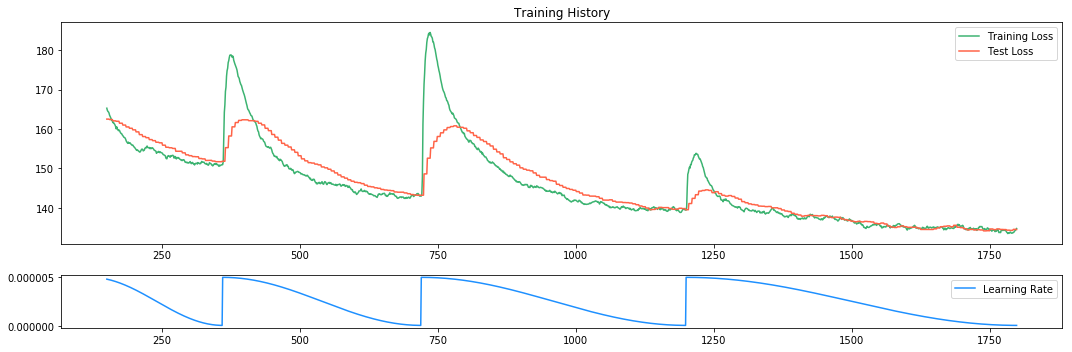

In [8]:
trainer.plot_history(skip_first=150);

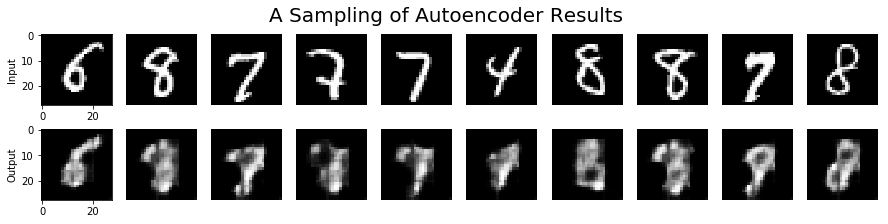

In [9]:
trainer.plot_input_output_pairs();

In [10]:
trainer.num_trainable_parameters

1596

### Relaxed Bottleneck

In [11]:
def train_convolutional_ae(conv_channels, learning_rate, cycles):
    trainer = get_trainer(conv_channels=conv_channels)
    trainer.multi_train(learning_rate=learning_rate, cycles=cycles)
    print(f'Final Test Loss: {trainer.test(): 0.3f}')
    print(f'Number of trainable parameters: {trainer.num_trainable_parameters}')
    trainer.plot_history()
    trainer.plot_input_output_pairs()

720/720 [==============================] - 26s 36ms/step - loss: 51.39572545276548 - val_loss: 51.20505148679675
Final Test Loss:  51.285
Number of trainable parameters: 19866


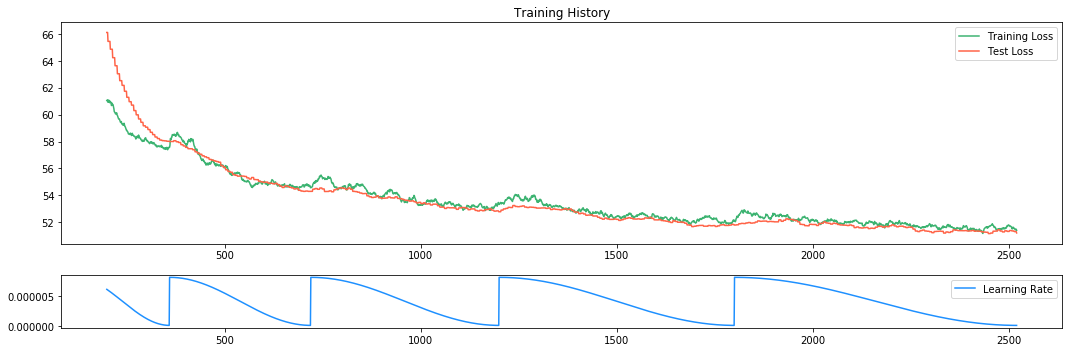

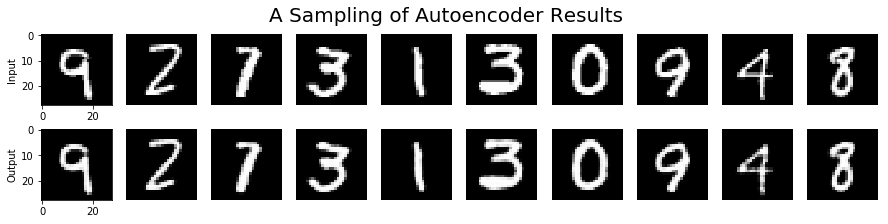

In [12]:
train_convolutional_ae(conv_channels=[4, 16, 64], learning_rate=8e-6, cycles=6)